In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset
data_m1 = pd.read_excel('data/M2.xlsx')

# Features (X) and target (y)
X_m1 = data_m1.drop('WPR', axis=1)
y_m1 = data_m1['WPR']

# Split data into training and testing sets
X_train_m1, X_test_m1, y_train_m1, y_test_m1 = train_test_split(X_m1, y_m1, test_size=0.2, random_state=42)


In [3]:
#Baseline model
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Baseline XGBoost model
xg_reg_baseline = xgb.XGBRegressor(objective='reg:squarederror', 
                                   colsample_bytree=0.3, 
                                   learning_rate=0.1, 
                                   max_depth=5, 
                                   n_estimators=100)
xg_reg_baseline.fit(X_train_m1, y_train_m1)

# Predictions for training and test sets
y_train_pred_baseline = xg_reg_baseline.predict(X_train_m1)
y_test_pred_baseline = xg_reg_baseline.predict(X_test_m1)

# Evaluate the baseline model
mse_train_baseline = mean_squared_error(y_train_m1, y_train_pred_baseline)
mse_test_baseline = mean_squared_error(y_test_m1, y_test_pred_baseline)

print("Baseline XGBoost MSE (Train): ", mse_train_baseline)
print("Baseline XGBoost MSE (Test): ", mse_test_baseline)


Baseline XGBoost MSE (Train):  0.30808851958306926
Baseline XGBoost MSE (Test):  0.35425646964408025


In [4]:
#PSO Optimization of hyperparameters
from pyswarm import pso

# Objective function for PSO
def pso_objective(params):
    learning_rate, max_depth, n_estimators = params
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', 
                              colsample_bytree=0.3, 
                              learning_rate=learning_rate, 
                              max_depth=int(max_depth), 
                              n_estimators=int(n_estimators))
    xg_reg.fit(X_train_m1, y_train_m1)
    predictions = xg_reg.predict(X_test_m1)
    return mean_squared_error(y_test_m1, predictions)

# Define bounds for learning_rate, max_depth, n_estimators
bounds = ([0.01, 3, 50], [0.2, 10, 200])

# Run PSO
best_params, best_mse = pso(pso_objective, bounds[0], bounds[1], swarmsize=50, maxiter=100)

print("Best Parameters from PSO:", best_params)
print("Best MSE from PSO:", best_mse)


Stopping search: Swarm best objective change less than 1e-08
Best Parameters from PSO: [  0.1191119    5.20029474 102.53759398]
Best MSE from PSO: 0.34774526853069915


In [5]:
#Train the model with the best hyperparameters from PSO
# xg_reg_pso = xgb.XGBRegressor(objective='reg:squarederror', 
#                               colsample_bytree=0.3, 
#                               learning_rate=best_params[0], 
#                               max_depth=int(best_params[1]), 
#                               n_estimators=int(best_params[2]))



 The best solution found:                                                                           
 [ 0.16154885  5.19808917 76.8198839 ]

 Objective function:
 0.35409701517748166


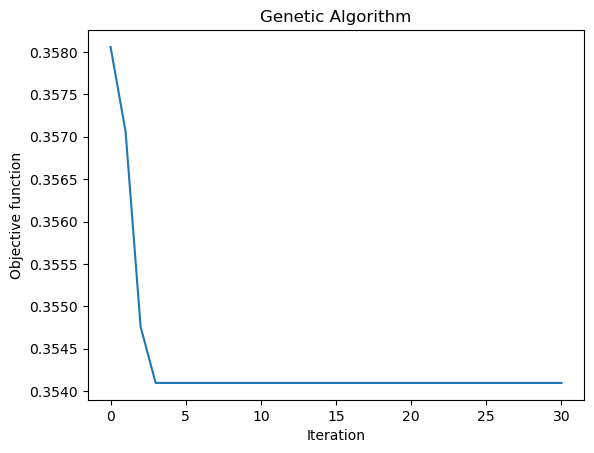


Best MSE from GA: 0.35409701517748166


In [7]:
#Genetic Algorithm Optimization of hyperparameters
from geneticalgorithm import geneticalgorithm as ga

def ga_objective(params):
    learning_rate, max_depth, n_estimators = params
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', 
                              colsample_bytree=0.3, 
                              learning_rate=learning_rate, 
                              max_depth=int(max_depth), 
                              n_estimators=int(n_estimators))
    xg_reg.fit(X_train_m1, y_train_m1)
    predictions = xg_reg.predict(X_test_m1)
    return mean_squared_error(y_test_m1, predictions)

varbound = np.array([[0.01, 0.2], [3, 10], [50, 200]])

model = ga(function=ga_objective, 
           dimension=3, 
           variable_type='real', 
           variable_boundaries=varbound,
           algorithm_parameters={
               'max_num_iteration': 100,  # Fewer iterations
               'population_size': 25,    # Smaller population
               'mutation_probability': 0.1,
               'elit_ratio': 0.01,
               'crossover_probability': 0.5,
               'parents_portion': 0.3,
               'crossover_type':'uniform',
               'max_iteration_without_improv': 25})

model.run()
best_params_ga = model.output_dict['variable']
print("Best Parameters from GA:", best_params_ga)
print("Best MSE from GA:", model.output_dict['function'])

In [ ]:
#Train the model with the best hyperparameters from GA
# xg_reg_ga = xgb.XGBRegressor(objective='reg:squarederror',
#                              colsample_bytree=0.3,
#                              learning_rate=best_params_ga[0],
#                              max_depth=int(best_params_ga[1]),


In [8]:
from niapy.task import Task
from niapy.algorithms.basic import HarrisHawksOptimization
from niapy.problems import Problem
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error

class XGBBenchmark(Problem):
    def __init__(self):
        # Call the parent class constructor with the dimension, lower, and upper bounds
        super().__init__(dimension=3, lower=[0.01, 3, 50], upper=[0.2, 10, 200])
        self.X_train = X_train_m1
        self.y_train = y_train_m1
        self.X_test = X_test_m1
        self.y_test = y_test_m1

    def _evaluate(self, x):
        learning_rate, max_depth, n_estimators = x
        xg_reg = xgb.XGBRegressor(objective='reg:squarederror', 
                                  colsample_bytree=0.3, 
                                  learning_rate=learning_rate, 
                                  max_depth=int(max_depth), 
                                  n_estimators=int(n_estimators))
        xg_reg.fit(self.X_train, self.y_train)
        predictions = xg_reg.predict(self.X_test)
        return mean_squared_error(self.y_test, predictions)

# Define the task
task = Task(problem=XGBBenchmark(), max_iters=100)

# Run the HHO algorithm
algorithm = HarrisHawksOptimization(population_size=30)
best_params_hho = algorithm.run(task=task)
print("Best Parameters from HHO:", best_params_hho[0])


Best Parameters from HHO: [ 0.12583413  5.77638456 79.94089191]


In [9]:
def train_and_evaluate(params, X_train, y_train, X_test, y_test):
    learning_rate, max_depth, n_estimators = params
    model = xgb.XGBRegressor(objective='reg:squarederror', 
                             colsample_bytree=0.3, 
                             learning_rate=learning_rate, 
                             max_depth=int(max_depth), 
                             n_estimators=int(n_estimators))
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    return mse_train, mse_test, y_train_pred, y_test_pred

# Evaluate PSO optimized model
mse_train_pso, mse_test_pso, y_train_pred_pso, y_test_pred_pso = train_and_evaluate(best_params, X_train_m1, y_train_m1, X_test_m1, y_test_m1)

# Evaluate GA optimized model
mse_train_ga, mse_test_ga, y_train_pred_ga, y_test_pred_ga = train_and_evaluate(best_params_ga, X_train_m1, y_train_m1, X_test_m1, y_test_m1)

# Evaluate HHO optimized model
mse_train_hho, mse_test_hho, y_train_pred_hho, y_test_pred_hho = train_and_evaluate(best_params_hho[0], X_train_m1, y_train_m1, X_test_m1, y_test_m1)

# Compare the results
print("PSO Optimized MSE (Train/Test):", mse_train_pso, mse_test_pso)
print("GA Optimized MSE (Train/Test):", mse_train_ga, mse_test_ga)
print("HHO Optimized MSE (Train/Test):", mse_train_hho, mse_test_hho)


PSO Optimized MSE (Train/Test): 0.296044715448727 0.34774526853069915
GA Optimized MSE (Train/Test): 0.28529015105623967 0.35409701517748166
HHO Optimized MSE (Train/Test): 0.3027804267601456 0.35018620017175756


In [10]:
# Save Baseline model predictions
baseline_results_train = pd.DataFrame({'GroundTruth': y_train_m1, 'Predictions': y_train_pred_baseline})
baseline_results_test = pd.DataFrame({'GroundTruth': y_test_m1, 'Predictions': y_test_pred_baseline})
baseline_results_train.to_csv('outputs/XGB_baseline_train_results.csv', index=False)
baseline_results_test.to_csv('outputs/XGB_baseline_test_results.csv', index=False)

# Save Optimized model predictions (PSO, GA, HHO)
optimized_results_train_pso = pd.DataFrame({'GroundTruth': y_train_m1, 'Predictions': y_train_pred_pso})
optimized_results_test_pso = pd.DataFrame({'GroundTruth': y_test_m1, 'Predictions': y_test_pred_pso})
optimized_results_train_pso.to_excel('outputs/M2XGB_optimized_train_results_pso.xlsx', index=False)
optimized_results_test_pso.to_excel('outputs/M2XGB_optimized_test_results_pso.xlsx', index=False)

optimized_results_train_ga = pd.DataFrame({'GroundTruth': y_train_m1, 'Predictions': y_train_pred_ga})
optimized_results_test_ga = pd.DataFrame({'GroundTruth': y_test_m1, 'Predictions': y_test_pred_ga})
optimized_results_train_ga.to_excel('outputs/M2XGB_optimized_train_results_ga.xlsx', index=False)
optimized_results_test_ga.to_excel('outputs/M2XGB_optimized_test_results_ga.xlsx', index=False)

optimized_results_train_hho = pd.DataFrame({'GroundTruth': y_train_m1, 'Predictions': y_train_pred_hho})
optimized_results_test_hho = pd.DataFrame({'GroundTruth': y_test_m1, 'Predictions': y_test_pred_hho})
optimized_results_train_hho.to_excel('outputs/M2XGB_optimized_train_results_hho.xlsx', index=False)
optimized_results_test_hho.to_excel('outputs/M2XGB_optimized_test_results_hho.xlsx', index=False)


In [11]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Define the objective function for Optuna
def objective(trial):
    # Suggest values for the parameters
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    
    # Create and train the model
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', 
                              colsample_bytree=0.3, 
                              learning_rate=learning_rate, 
                              max_depth=max_depth, 
                              n_estimators=n_estimators)
    
    xg_reg.fit(X_train_m1, y_train_m1)
    
    # Predict on the test set
    predictions = xg_reg.predict(X_test_m1)
    
    # Calculate MSE
    mse = mean_squared_error(y_test_m1, predictions)
    
    return mse

# Create a study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Best parameters and the corresponding MSE
best_params_bbo = study.best_params
best_mse_bbo = study.best_value

print("Best Parameters from BBO (Optuna):", best_params_bbo)
print("Best MSE from BBO (Optuna):", best_mse_bbo)


/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-09-01 07:29:17,116] A new study created in memory with name: no-name-0183f538-b83e-4ec6-ab80-5a07b794e72a
[I 2024-09-01 07:29:17,257] Trial 0 finished with value: 0.35984794340198517 and parameters: {'learning_rate': 0.15147852204010637, 'max_depth': 4, 'n_estimators': 72}. Best is trial 0 with value: 0.35984794340198517.
[I 2024-09-01 07:29:17,717] Trial 1 finished with value: 0.44868375261598137 and parameters: {'learning_rate': 0.0957917685480718, 'max_depth': 10, 'n_estimators': 121}. Best is trial 0 with value: 0.35984794340198517.
[I 2024-09-01 07:29:17,873] Trial 2 finished with value: 0.3980112863133231 and parameters: {'learning_rate': 0.09680989846380543, 'max_depth': 8, 'n_estimators': 66}. Best is trial 

Best Parameters from BBO (Optuna): {'learning_rate': 0.12646417181003783, 'max_depth': 5, 'n_estimators': 90}
Best MSE from BBO (Optuna): 0.3516877377644093


In [12]:
# Train and evaluate the BBO optimized model
mse_train_bbo, mse_test_bbo, y_train_pred_bbo, y_test_pred_bbo = train_and_evaluate(
    [best_params_bbo['learning_rate'], best_params_bbo['max_depth'], best_params_bbo['n_estimators']], 
    X_train_m1, y_train_m1, X_test_m1, y_test_m1
)

# Compare the results with other models
print("PSO Optimized MSE (Train/Test):", mse_train_pso, mse_test_pso)
print("GA Optimized MSE (Train/Test):", mse_train_ga, mse_test_ga)
print("HHO Optimized MSE (Train/Test):", mse_train_hho, mse_test_hho)
print("BBO (Optuna) Optimized MSE (Train/Test):", mse_train_bbo, mse_test_bbo)


PSO Optimized MSE (Train/Test): 0.296044715448727 0.34774526853069915
GA Optimized MSE (Train/Test): 0.28529015105623967 0.35409701517748166
HHO Optimized MSE (Train/Test): 0.3027804267601456 0.35018620017175756
BBO (Optuna) Optimized MSE (Train/Test): 0.2955155701937141 0.3516877377644093


In [13]:
# Save BBO (Optuna) optimized model predictions
optimized_results_train_bbo = pd.DataFrame({'GroundTruth': y_train_m1, 'Predictions': y_train_pred_bbo})
optimized_results_test_bbo = pd.DataFrame({'GroundTruth': y_test_m1, 'Predictions': y_test_pred_bbo})
optimized_results_train_bbo.to_excel('outputs/M2optimized_train_results_bbo.xlsx', index=False)
optimized_results_test_bbo.to_excel('outputs/M2optimized_test_results_bbo.xlsx', index=False)


In [ ]:
print("Done!")